# Reproduce the Grokking moment of LLM
### -- Using addition module p as an example

Source: https://youtu.be/D8GOeCFFby4?si=-OmGfudmRexcHa-d
OpenAI team’s grokking paper: https://arxiv.org/pdf/2201.02177.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import random
import math

In [2]:
# --- BLOCK 1: CONFIGURATION ---
class Config:
    def __init__(self):
        # Task Parameters
        self.p = 113              # Modulo (User requested 5)
                                # NOTE: Grokking is more dramatic at p=97 or p=113.
        self.frac_train = 0.5   # 50% training data

        # Model Architecture (Single Layer Transformer)
        self.d_model = 128      # Embedding dimension
        self.n_heads = 4        # Number of heads
        self.d_head = self.d_model // self.n_heads
        self.n_layers = 1       # Single layer (per video recommendation)
        self.d_mlp = 512        # MLP expansion factor (4x)
        self.act_fn = "relu"

        # Optimization (The "Goldilocks" hyperparameters)
        self.lr = 1e-3          # Learning rate
        self.weight_decay = 0.9 # CRITICAL: High weight decay forces grokking
        self.num_epochs = 10000  # Grokking takes time; 5k-10k epochs often needed
        self.batch_size = -1    # Full batch training reduces noise
        self.seed = 42
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

In [3]:
# --- BLOCK 2: DATA GENERATION ---
def generate_data(p, frac_train):
    """
    Generates dataset for Modular Addition: a + b = c (mod p).
    Input format: sequence [a, b, =]
    Target: c
    """
    # Tokens: 0 to p-1 are numbers. p is the '=' token.
    equals_token = p
    data = []
    targets = []

    for x in range(p):
        for y in range(p):
            # Sequence: x, y, =
            seq = [x, y, equals_token]
            label = (x + y) % p
            data.append(seq)
            targets.append(label)

    data = torch.tensor(data, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    # Random Split
    n_samples = len(data)
    n_train = int(n_samples * frac_train)
    indices = torch.randperm(n_samples)

    train_x = data[indices[:n_train]]
    train_y = targets[indices[:n_train]]
    test_x = data[indices[n_train:]]
    test_y = targets[indices[n_train:]]

    return train_x, train_y, test_x, test_y


In [4]:
# --- BLOCK 3: MODEL ARCHITECTURE ---
# Standard Decoder-Only Transformer implementation
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model) / math.sqrt(d_model))

    def forward(self, x):

        return x + self.W_pos[:x.shape[-2]]

class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.eps = 1e-5
        self.w = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        return self.w * (x - mean) / torch.sqrt(var + self.eps) + self.b

class MultiHeadAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_heads = cfg.n_heads
        self.d_head = cfg.d_head
        self.scale = 1.0 / math.sqrt(self.d_head)

        # Q, K, V projections
        self.W_QKV = nn.Linear(cfg.d_model, 3 * cfg.d_model, bias=False)
        self.W_O = nn.Linear(cfg.d_model, cfg.d_model, bias=False)

    def forward(self, x):
        B, L, D = x.shape
        qkv = self.W_QKV(x)
        q, k, v = torch.split(qkv, D, dim=-1)

        # Reshape handles non-contiguous inputs automatically
        q = q.reshape(B, L, self.n_heads, self.d_head).transpose(1, 2)
        k = k.reshape(B, L, self.n_heads, self.d_head).transpose(1, 2)
        v = v.reshape(B, L, self.n_heads, self.d_head).transpose(1, 2)

        # Attention Mechanism
        # Scores: (B, H, L, L)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale

        # Causal Mask (prevent looking at future tokens, though less critical for [a,b,=])
        mask = torch.triu(torch.ones(L, L, device=x.device), diagonal=1).bool()
        attn_scores = attn_scores.masked_fill(mask, -1e9)
        attn_probs = F.softmax(attn_scores, dim=-1)

        # Aggregate
        out = attn_probs @ v
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.W_O(out)

class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_mlp), # net[0]
            nn.ReLU(),                         # net[1]
            nn.Linear(cfg.d_mlp, cfg.d_model)  # net[2]
        )

        # Correct manual initialization for Grokking
        std_dev = 1.0 / math.sqrt(cfg.d_model)
        for module in self.net:
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=std_dev)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(cfg)
        self.ln1 = LayerNorm(cfg.d_model)
        self.mlp = MLP(cfg)
        self.ln2 = LayerNorm(cfg.d_model)

    def forward(self, x):
        # Pre-LN architecture (standard for modern transformers)
        # x = x + self.attn(self.ln1(x))
        # x = x + self.mlp(self.ln2(x)) # multi layer perceptron

        # Remove layer norm. We want the raw sine waves to add up constructively.
        # LayerNorm can "squash" these periodic signals,
        # making them much harder to visualize and sometimes delaying the grokking phase
        x = x + self.attn(x)
        x = x + self.mlp(x) # multi layer perceptron
        return x

class GrokkingTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.vocab_size = cfg.p + 1 # 0..p-1 and '='
        self.embed = Embed(self.vocab_size, cfg.d_model)
        self.pos_embed = PosEmbed(3, cfg.d_model) # context len 3

        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg.d_model)
        self.unembed = Unembed(self.vocab_size, cfg.d_model)

    def forward(self, x):
        # x shape: (Batch, Seq_Len=3)
        x = self.embed(x)
        # x shape: (Batch, 3, d_model)

        x = self.pos_embed(x)

        for block in self.blocks:
            x = block(x)

        # remove layer norm
        # x = self.ln_final(x)

        # x shape: (Batch, 3, d_model)
        logits = self.unembed(x)
        # logits shape: (Batch, 3, Vocab_Size)

        # We generally return all logits and slice later,
        # or slice here if we only ever care about the last token prediction.
        return logits


In [5]:
# --- BLOCK 4: TRAINING & VISUALIZATION ---
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

# ... inside train_and_grok ...


def train_and_grok():
    print(f"--- Experiment: Modulo {config.p} Addition ---")

    # 1. Prepare Data
    train_x, train_y, test_x, test_y = generate_data(config.p, config.frac_train)
    train_x, train_y = train_x.to(config.device), train_y.to(config.device)
    test_x, test_y = test_x.to(config.device), test_y.to(config.device)

    # 2. Setup Model
    model = GrokkingTransformer(config).to(config.device)

    # CRITICAL: High Weight Decay (1.0)
    optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, betas=(0.9, 0.98))

    # 1. Warmup for 100 steps
    warmup = LinearLR(optimizer, start_factor=1e-10, end_factor=1.0, total_iters=200)

    # 2. Decay for the rest of the steps
    decay = CosineAnnealingLR(optimizer, T_max=config.num_epochs - 200)

    # 3. Combine them
    scheduler = SequentialLR(optimizer, schedulers=[warmup, decay], milestones=[200])
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/100, 1)) # Warmup only
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'epochs': []}

    # 3. Training Loop
    for epoch in range(config.num_epochs):
        model.train()
        logits = model(train_x)
        last_token_logits = logits[:, -1, :]
        loss = criterion(last_token_logits, train_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 500 == 0:
            model.eval()
            with torch.no_grad():
                test_logits = model(test_x)[:, -1, :]
                test_loss = criterion(test_logits, test_y).item()
                train_acc = (last_token_logits.argmax(dim=-1) == train_y).float().mean().item()
                test_acc = (test_logits.argmax(dim=-1) == test_y).float().mean().item()

                history['train_loss'].append(loss.item())
                history['test_loss'].append(test_loss)
                history['train_acc'].append(train_acc)
                history['test_acc'].append(test_acc)
                history['epochs'].append(epoch)

                print(f"Epoch {epoch:05d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

    return model, history

In [6]:
# --- BLOCK 5: VISUALIZATION ---

def visualize_pre_activations(model, config):
    model.eval()
    p = config.p
    device = next(model.parameters()).device

    # --- Hook Setup ---
    # We want PRE-Activation. Structure: blocks[0] -> mlp -> net -> [Linear, ReLU, Linear]
    # Index 0 is the first Linear layer.
    mlp_pre_acts = {}
    def get_activation(name):
        def hook(model, input, output):
            mlp_pre_acts[name] = output.detach()
        return hook

    # Register hook to the Linear layer (before ReLU)
    hook_handle = model.blocks[0].mlp.net[0].register_forward_hook(get_activation('mlp_pre'))

    # --- Data Sweep (Fix a=0, sweep b) ---
    print("\n--- Generating Visualization Data ---")
    a_fixed = 0
    b_sweep = torch.arange(p)
    eq_token = torch.full((p,), p)
    inputs = torch.stack([torch.full((p,), a_fixed), b_sweep, eq_token], dim=1).to(device)

    with torch.no_grad():
        _ = model(inputs)

    # Retrieve Pre-Activations at last token
    # Shape: (p, d_mlp)
    act_data = mlp_pre_acts['mlp_pre'][:, -1, :].cpu().numpy()
    # --- CHANGED SELECTION LOGIC ---
    # Option A: First 7 Neurons (Default)
    # top_7_indices = np.arange(7)

    # Option B: Random 7 Neurons (Uncomment below to use)
    top_7_indices = np.random.choice(config.d_mlp, 7, replace=False)

    top_7_acts = act_data[:, top_7_indices]

    colors = b_sweep.cpu().numpy()

    # --- PLOT 1: Selected 7 Pre-Activations (Vertical Stack) ---
    fig, axes = plt.subplots(7, 1, figsize=(8, 12), sharex=True)
    fig.suptitle(f"Selected 7 MLP Pre-Activations (a={a_fixed}, b=0..{p-1})", fontsize=16)

    for i, ax in enumerate(axes):
        neuron_idx = top_7_indices[i]
        ax.scatter(colors, top_7_acts[:, i], c=colors, cmap='viridis', s=15)
        ax.set_ylabel(f'N{neuron_idx}')
        ax.grid(True, alpha=0.3)
        if i == 6: ax.set_xlabel("Input b")
        else: ax.set_xticklabels([])
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: 7x7 Correlations (Lissajous) ---
    fig, axes = plt.subplots(7, 7, figsize=(12, 12))
    fig.suptitle("Pre-Activation Phase Portraits (Selected 7)", fontsize=16)

    for row in range(7):
        for col in range(7):
            ax = axes[row, col]
            x_vals = top_7_acts[:, col]
            y_vals = top_7_acts[:, row]
            ax.scatter(x_vals, y_vals, c=colors, cmap='viridis', s=2)
            ax.set_xticks([])
            ax.set_yticks([])
            if row == 6: ax.set_xlabel(f'N{top_7_indices[col]}')
            if col == 0: ax.set_ylabel(f'N{top_7_indices[row]}')
    plt.tight_layout()
    plt.show()

    # --- PLOT 3: Embedding Periodicity (Separate Graphs) ---
    print("--- 3. Embedding Frequency Analysis (Sweep a) ---")

    # Access Embedding Weights
    W_E = model.embed.W_E.detach().cpu().numpy() # (d_model, vocab)

    # Pick 6 random dimensions
    d_model = config.d_model
    random_dims = random.sample(range(d_model), 6)

    # Slice weights for tokens 0..p-1
    embed_vals = W_E[random_dims, 0:p].T # (p, 6)
    a_colors = np.arange(p)

    fig, axes = plt.subplots(6, 1, figsize=(8, 10), sharex=True)
    fig.suptitle(f"6 Random Embedding Dimensions (a=0..{p-1})", fontsize=16)

    for i, ax in enumerate(axes):
        dim_idx = random_dims[i]
        # Scatter plot for embeddings
        ax.scatter(a_colors, embed_vals[:, i], c=a_colors, cmap='cool', s=15)
        ax.set_ylabel(f'Dim {dim_idx}')
        ax.grid(True, alpha=0.3)

        if i < 5:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Input a")

    plt.tight_layout()
    plt.show()

    # Plot 3b: Average (Optional, keeping as single line for contrast or scatter)
    avg_embed = np.mean(embed_vals, axis=1)
    plt.figure(figsize=(10, 4))
    plt.scatter(a_colors, avg_embed, c=a_colors, cmap='cool', s=20)
    plt.plot(a_colors, avg_embed, alpha=0.3, color='gray') # Connect lines faintly
    plt.title("Average of 6 Random Embedding Dimensions")
    plt.xlabel("Input a")
    plt.ylabel("Average Value")
    plt.grid(True, alpha=0.3)
    plt.show()

    hook_handle.remove()

--- Experiment: Modulo 113 Addition ---
Epoch 00000 | Train Loss: 4.7632 | Test Loss: 4.7624 | Train Acc: 1.02% | Test Acc: 0.72%


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00500 | Train Loss: 0.0013 | Test Loss: 1.1019 | Train Acc: 100.00% | Test Acc: 73.97%
Epoch 01000 | Train Loss: 0.0000 | Test Loss: 0.0696 | Train Acc: 100.00% | Test Acc: 97.87%
Epoch 01500 | Train Loss: 0.0000 | Test Loss: 0.0000 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 02000 | Train Loss: 0.0006 | Test Loss: 0.0009 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 02500 | Train Loss: 0.0001 | Test Loss: 0.0003 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 03000 | Train Loss: 0.0000 | Test Loss: 0.0000 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 03500 | Train Loss: 0.0001 | Test Loss: 0.0002 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 04000 | Train Loss: 0.0001 | Test Loss: 0.0002 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 04500 | Train Loss: 0.0000 | Test Loss: 0.0000 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 05000 | Train Loss: 0.0001 | Test Loss: 0.0001 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch 05500 | Train Loss: 0.0000 | Test Loss: 0.0000 | Train A

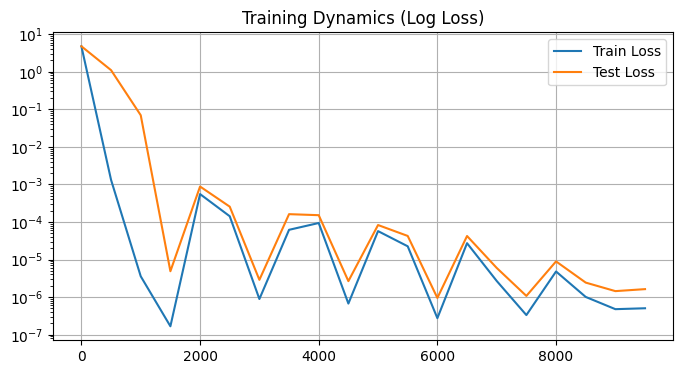


--- Generating Visualization Data ---


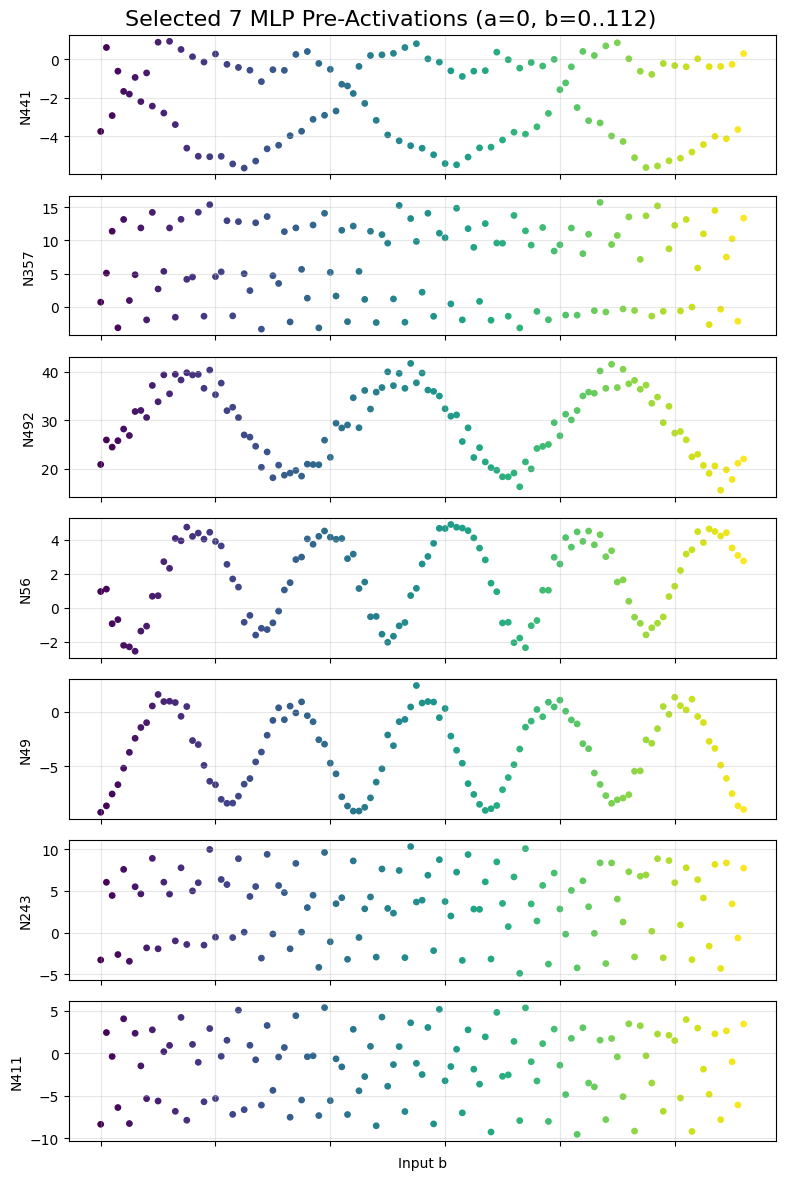

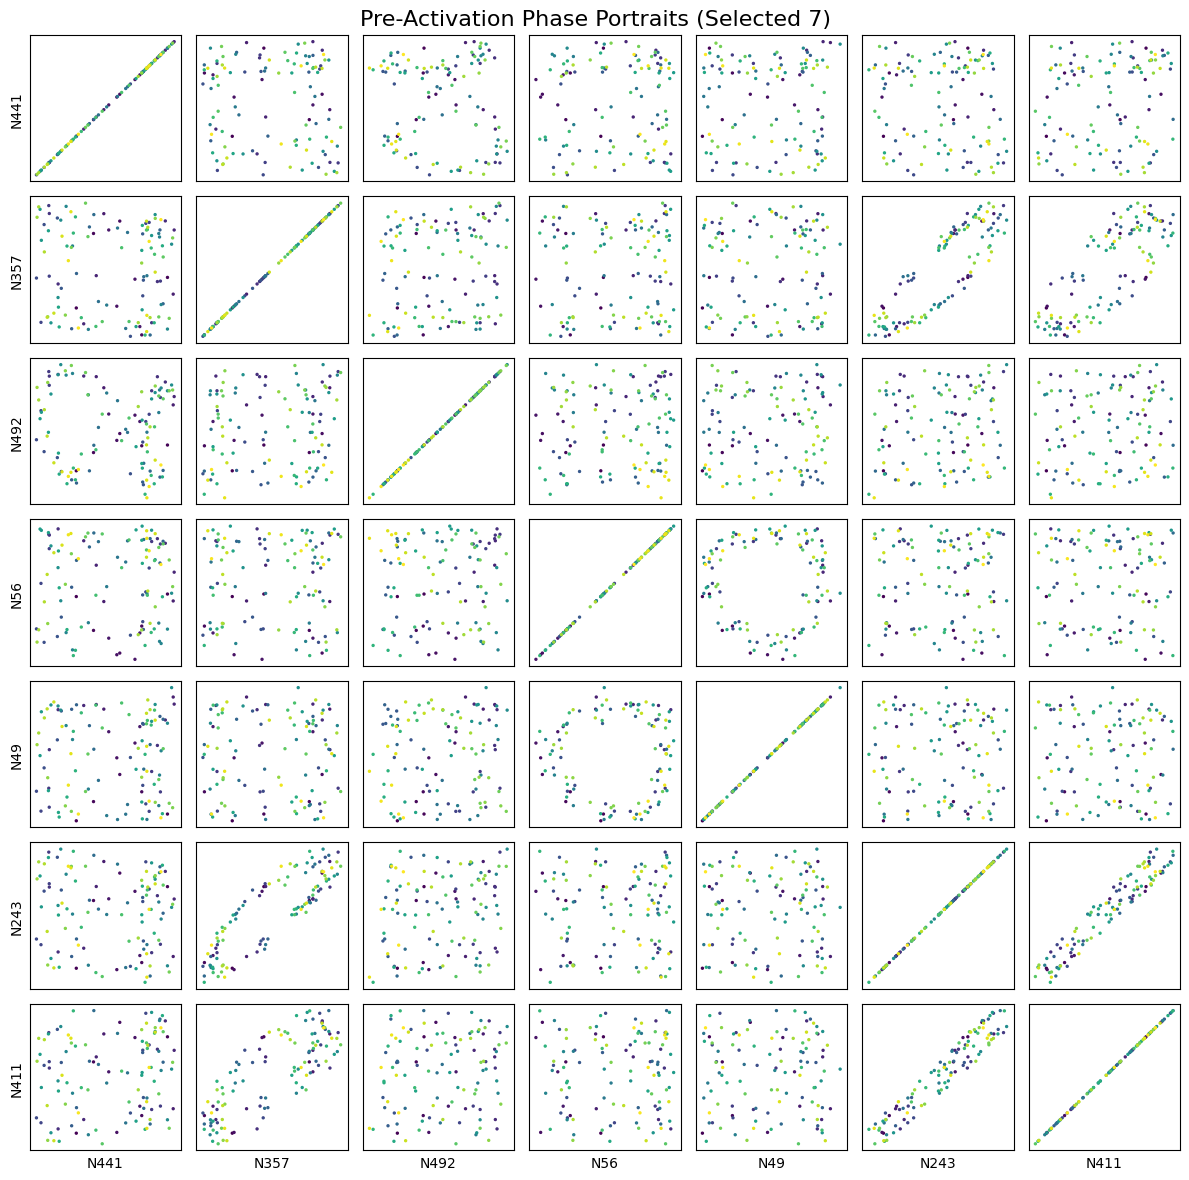

--- 3. Embedding Frequency Analysis (Sweep a) ---


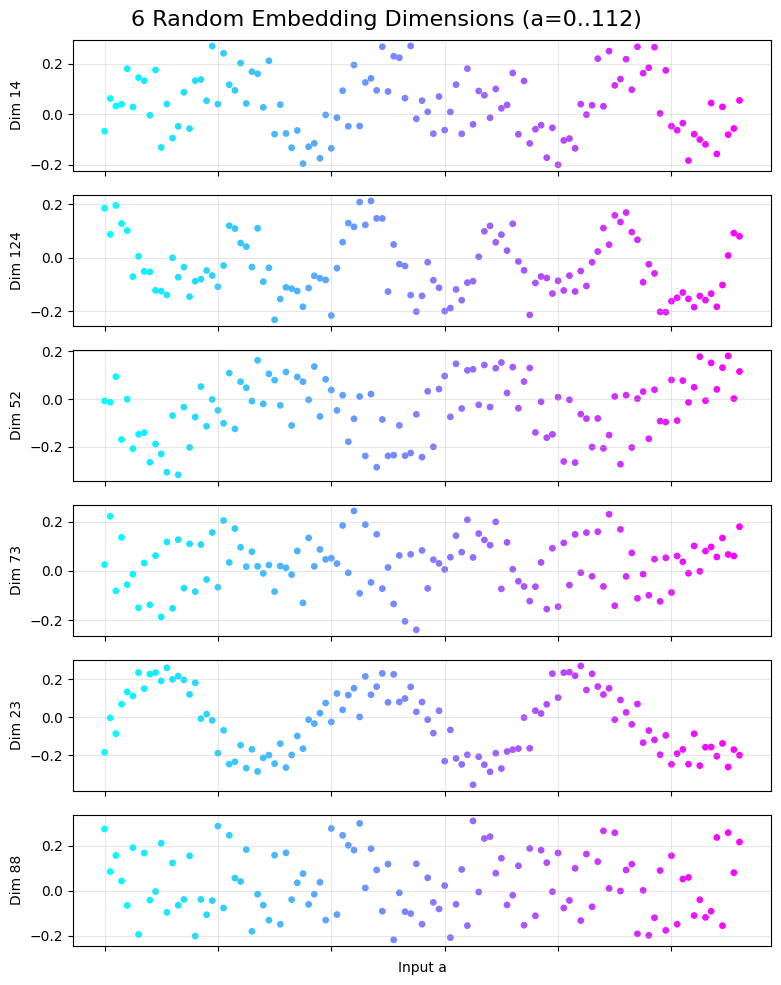

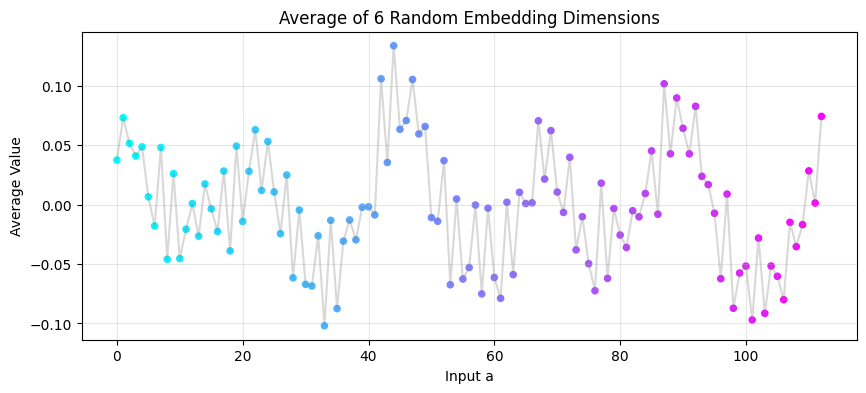

In [7]:
if __name__ == "__main__":
    # 1. Train the model
    model, history = train_and_grok()

    # Optional: Plot training loss to verify grokking happened
    plt.figure(figsize=(8, 4))
    plt.plot(history['epochs'], history['train_loss'], label='Train Loss')
    plt.plot(history['epochs'], history['test_loss'], label='Test Loss')
    plt.yscale('log')
    plt.title('Training Dynamics (Log Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Run the requested visualization
    # We fix the first token to 0 and look at the first 7 neurons
    visualize_pre_activations(model, config)